In [1]:
import numpy as np
from collections import deque
from dd_class import Dragodinde
from dd_class import Elevage
import random
import time

In [12]:
# Define the structure for each object
class LinkGeneration:
    def __init__(self, color, generation, next_colors):
        self.color = color
        self.generation = generation
        self.next_colors = next_colors

    def __repr__(self):
        return f"color:{self.color}, generation:{self.generation}, next_colors:{self.next_colors})"

    # Getter for color
    def get_color(self):
        return self.color

    # Getter for generation
    def get_generation(self):
        return self.generation

    # Getter for next_colors
    def get_ancestor(self):
        return self.next_colors
    
# Define the list of objects (example data)
color_generation_list = [
    [
        LinkGeneration("Dorée", 1, []),
        LinkGeneration("Amande", 1, []),
        LinkGeneration("Rousse", 1, [])
    ],[
        LinkGeneration("Amande et Rousse", 2, ["Amande", "Rousse"]),
        LinkGeneration("Amande et Dorée", 2, ["Amande", "Dorée"]),
        LinkGeneration("Dorée et Rousse", 2, ["Dorée", "Rousse"])
    ],[
        LinkGeneration("Indigo", 3, ["Amande et Dorée", "Dorée et Rousse"]),
        LinkGeneration("Ebène", 3, ["Amande et Rousse", "Dorée et Rousse"])
    ],[
        LinkGeneration("Ebène et Indigo", 4, ["Ebène", "Indigo"]),
    ],[
        LinkGeneration("Pourpre", 5, ["Ebène et Indigo", "Indigo"]),
        LinkGeneration("Orchidée", 5, ["Ebène", "Ebène et Indigo"])
    ],[
        LinkGeneration("Ebène et Orchidée", 6, ["Ebène", "Orchidée"]),
        LinkGeneration("Orchidée et Pourpre", 6, ["Orchidée", "Pourpre"]),
        LinkGeneration("Indigo et Pourpre", 6, ["Indigo", "Pourpre"])
    ],[
        LinkGeneration("Ivoire", 7, ["Orchidée et Pourpre", "Indigo et Pourpre"]),
        LinkGeneration("Turquoise", 7, ["Ebène et Orchidée", "Orchidée et Pourpre"])
    ],[
        LinkGeneration("Turquoise et Orchidée", 8, ["Turquoise", "Orchidée"]),
        LinkGeneration("Ivoire et Turquoise", 8, ["Ivoire", "Turquoise"]),
        LinkGeneration("Ivoire et Pourpre", 8, ["Ivoire", "Pourpre"])
    ],[
        LinkGeneration("Emeraude", 9, ["Ivoire et Pourpre", "Ivoire et Turquoise"]),
        LinkGeneration("Prune", 9, ["Turquoise et Orchidée", "Ivoire et Turquoise"])
    ],[
        LinkGeneration("Prune et Emeraude", 10, ["Emeraude", "Prune"])
    ]
]

class Models :
    def __init__(self) :
        self.elevage = self.create_elevage()
        self.interred_dd = color_generation_list

    def __str__(self) :
        return (f"{self.elevage}")
    
    def get_length_elevage(self) :
        return len(self.elevage.get_dragodindes())
    
    def get_better_generation(self) :
        better_generation = 1
        for dragodinde in self.elevage.get_dragodindes() :
            generation = dragodinde.get_generation()
            if generation > better_generation :
                better_generation = generation
        
        return better_generation

    def get_dd_better_generation(self, dragodindes) :
        better_generation = 1
        list_better_dd = []
        for idx, dragodinde in enumerate(dragodindes) :
            generation  = dragodinde.get_generation()
            if generation > better_generation :
                list_better_dd = []
                better_generation = generation
                list_better_dd.append(dragodindes[idx])
            elif generation == better_generation :
                list_better_dd.append(dragodindes[idx])

        return list_better_dd

    def create_elevage(self):

        dragodindes_data = [
            (1, "M", "Rousse", 1),
            (2, "F", "Rousse", 1),
            (3, "M", "Amande", 1),
            (4, "F", "Amande", 1),
            (5, "M", "Dorée", 1),
            (6, "F", "Dorée", 1)
        ]

        list_dd = []
        for id, gender, color, generation in dragodindes_data:
            dragodinde = Dragodinde(id, gender, color, generation)
            list_dd.append(dragodinde)

        return Elevage(list_dd)
    
    def strategy_random_crosing(self):
        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]

        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")

        male = random.choice(males)
        female = random.choice(females)

        # Assuming accouplement_naissance is a method that performs crossing and returns probabilities
        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)

        return nouvelle_dd
    
    def strategy_crosing_better_gen(self):
        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]

        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")

        # Take the best generation
        list_better_males = self.get_dd_better_generation(males)
        list_better_females = self.get_dd_better_generation(females)

        if list_better_males[0].get_generation() > list_better_females[0].get_generation():
            male = random.choice(males)
            female = random.choice(list_better_females)
        
        elif list_better_males[0].get_generation() <= list_better_females[0].get_generation():
            male = random.choice(list_better_males)
            female = random.choice(females)

        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)
        return nouvelle_dd

    def is_in_every_sublist(self, lst, target):
        for item in lst:
            if isinstance(item, list):
                if not self.is_in_every_sublist(item, target):  # Recursively check sublists
                    return False
            elif item != target:
                return False
        return True
    
    # List the quality of purety of a list of dd
    def check_purity(self, list_dd : list, purity=3) -> list :
        """
        Purity : Thresold of purity (same color) quality
        (0 : only ind is pur, 1 : ind + parent, ...)
        """
        list_pur = []        
        for dd in list_dd :
            list_color_dd = dd.get_arbre_genealogique().get_genealogie(purity)
            color_ind = dd.get_color()

            # Case no genealogie or not all generation present
            if not list_color_dd or self.is_in_every_sublist(list_color_dd, color_ind) : 
                list_pur.append(dd)

        return list_pur

    def identify_crosing(self, males, females):
        target_generation = 9  # The final generation we want to achieve
        male = None
        female = None

        color_males = [dd.get_color() for dd in males]
        color_females = [dd.get_color() for dd in females]

        # check if male and female are pure 
        pure_males = self.check_purity(males)
        pure_females = self.check_purity(females)
        color_pure_males = [dd.get_color() for dd in pure_females]
        color_pure_females = [dd.get_color() for dd in pure_females]
        saved_ancestor_color = {"M" : [], "F" : []}

        # print("color_males : ", color_males)
        # print("color_females : ", color_females)
        # print("pure_males : ", pure_males)
        # print("pure_females : ", pure_females)
        # print("color_pure_males : ", color_pure_males)
        # print("color_pure_females : ", color_pure_females)

        # Start by checking from the last generation that needs to be achieved
        for gen in range(target_generation, 0, -1):

            #print("gen : ", gen)
            # Loop over the interested dd to check if there are all of them to create new dd
            if gen % 2 == 0 :
                bool_interested_dd_all_present = [True] * 2
            else : 
                bool_interested_dd_all_present = [True] * 3

            for idx, interested_dd in enumerate(self.interred_dd[gen]) :

                #print("interested_dd : ", interested_dd)
                # check if in the next generation there are not male & female already existing for this interested_dd
                if interested_dd.get_color() in color_pure_males :
                    print("why")
                    saved_ancestor_color["M"].append(interested_dd.get_color())

                if interested_dd.get_color() in color_pure_females :
                    print("why why")
                    saved_ancestor_color["F"].append(interested_dd.get_color())

                # Case : interrested dd not pur or next generation are already pur
                if ((interested_dd.get_color() not in color_pure_males or interested_dd.get_color() not in color_pure_females) \
                    or (interested_dd.get_color() in saved_ancestor_color["M"] and interested_dd.get_color() in saved_ancestor_color["F"])) \
                    and (interested_dd.get_color() in color_males or interested_dd.get_color() in color_females) :

                    print("et pourtant")
                    bool_interested_dd_all_present[idx] = False

                    # Case : can be purify 
                    if interested_dd.get_color() in color_males and interested_dd.get_color() in color_females :
                        return males[color_males.index(interested_dd.get_color())], females[color_males.index(interested_dd.get_color())]

            # Case : generation are not present but the ancestor are pure and we can create new generation
            for bool_interested, interested_dd in zip(bool_interested_dd_all_present, self.interred_dd[gen]) :

                if bool_interested and (all(elem in color_pure_males for elem in interested_dd.get_ancestor()) and all(elem in color_pure_females for elem in interested_dd.get_ancestor())) :
                    print("interested_dd.get_ancestor() : ", interested_dd.get_ancestor())
                    print("color_pure_males : ", color_pure_males)
                    print("color_pure_females : ", color_pure_females)

                    result0 = all(elem in color_pure_males for elem in interested_dd.get_ancestor())
                    print("result0 : ", result0)  # True if all elements in list1 are in list2, otherwise False

                    result1 = all(elem in color_pure_females for elem in interested_dd.get_ancestor())
                    print("result1 : ", result1)  # True if all elements in list1 are in list2, otherwise False

                    return pure_males[color_males.index(interested_dd.get_ancestor()[0])], pure_females[color_males.index(interested_dd.get_ancestor()[1])]
                
        raise ValueError("male and female not paired in indentify_dd()")

    def strategy_select_and_purify(self) :
        # Intuition:
        # Identify dd that need to be crossed to create a 10th-generation dd
        # Identify dd that need to be purified (while the n-1 generation dd is available)
        # Purify and lock the selected dd (M and F)
        # While a selected dd is identified (color) and gen n - 1 is purified
        # Do crossing / purification step   

        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]

        # Identify dd that need to be created of purify 
        male, female = self.identify_crosing(males, females)
        print("male, female : ", male.get_color(), female.get_color())
        
        # Crossing each other
        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)
        print("new born : ", nouvelle_dd.get_color())
        return nouvelle_dd

In [ ]:
import matplotlib.pyplot as plt
 
def plot_simlation(list_simulation) : 
    x_values = list(range(len(list_simulation)))

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plotting the two lists
    plt.plot(x_values, list_simulation, label='Generation List', color='blue')
    plt.ylim(0, 11)

    # Adding labels and title
    plt.xlabel('Number of Croisement')
    plt.ylabel('Generation Number')
    plt.title('Plot of Generation Numbers per Croisement')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

## Model 1 : random crosing

In [3]:
elevage = Models()
list_random = [1]
better_generation = 1
crosing_number = 1000
for i in range(crosing_number) :
    new_dd = elevage.strategy_random_crosing()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_random.append(better_generation)

In [ ]:
plot_simlation(list_random) 

## Model 2 : Best generation crosing

In [4]:
elevage = Models()
better_generation = 1
list_gen_upgrade_random = [1]
crosing_number = 1000
for i in range(crosing_number) :
    new_dd = elevage.strategy_crosing_better_gen()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_gen_upgrade_random.append(better_generation)

In [ ]:
plot_simlation(list_gen_upgrade_random) 

## Model 3 : Select and purify crosing

In [17]:
elevage = Models()
better_generation = 1
list_select_purify = [1]
crosing_number = 100
for i in range(crosing_number) :
    new_dd = elevage.strategy_select_and_purify()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_select_purify.append(better_generation)

interested_dd.get_ancestor() :  ['Amande', 'Rousse']
color_pure_males :  ['Rousse', 'Amande', 'Dorée']
color_pure_females :  ['Rousse', 'Amande', 'Dorée']
result0 :  True
result1 :  True
male, female :  Amande Rousse
new born :  Amande
interested_dd.get_ancestor() :  ['Amande', 'Rousse']
color_pure_males :  ['Rousse', 'Amande', 'Dorée']
color_pure_females :  ['Rousse', 'Amande', 'Dorée']
result0 :  True
result1 :  True
male, female :  Amande Rousse
new born :  Rousse
interested_dd.get_ancestor() :  ['Amande', 'Rousse']
color_pure_males :  ['Rousse', 'Amande', 'Dorée']
color_pure_females :  ['Rousse', 'Amande', 'Dorée']
result0 :  True
result1 :  True
male, female :  Amande Rousse
new born :  Rousse
interested_dd.get_ancestor() :  ['Amande', 'Rousse']
color_pure_males :  ['Rousse', 'Amande', 'Dorée']
color_pure_females :  ['Rousse', 'Amande', 'Dorée']
result0 :  True
result1 :  True
male, female :  Amande Rousse
new born :  Amande
interested_dd.get_ancestor() :  ['Amande', 'Rousse']
col

IndexError: list index out of range

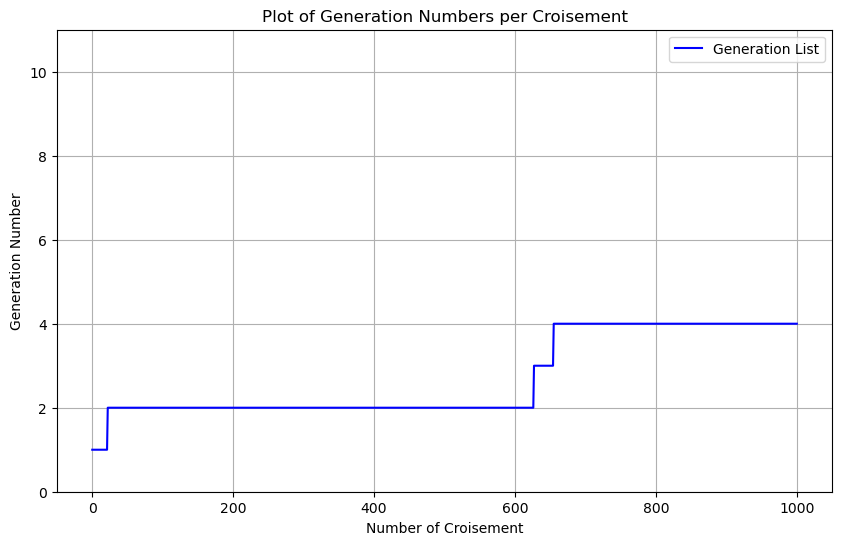

In [16]:
plot_simlation(list_select_purify)

In [ ]:
list_simulation_random = []

for i in range(100) :
    elevage = Models()
    list_gen_upgrade_random = [1]
    crosing_number = 1000
    better_generation = 1
    for i in range(crosing_number) :
        new_dd = elevage.strategy_random_crosing()
        generation = new_dd.get_generation()
        if generation > better_generation :
            better_generation = generation
        list_gen_upgrade_random.append(better_generation)
    list_simulation_random.append(list_gen_upgrade_random)

In [ ]:
list_simulation_better_gen = []

for i in range(100) :
    elevage = Models()
    list_gen_upgrade_random = [1]
    crosing_number = 1000
    better_generation = 1
    for i in range(crosing_number) :
        new_dd = elevage.strategy_crosing_better_gen()
        generation = new_dd.get_generation()
        if generation > better_generation :
            better_generation = generation
        list_gen_upgrade_random.append(better_generation)
    list_simulation_better_gen.append(list_gen_upgrade_random)

In [ ]:
list_simulation_select_purify = []

for i in range(100) :
    elevage = Models()
    list_gen_upgrade_random = [1]
    crosing_number = 1000
    better_generation = 1
    for i in range(crosing_number) :
        new_dd = elevage.strategy_select_and_purify()
        generation = new_dd.get_generation()
        if generation > better_generation :
            better_generation = generation
        list_gen_upgrade_random.append(better_generation)
    list_simulation_select_purify.append(list_gen_upgrade_random)

IndexError: list index out of range

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


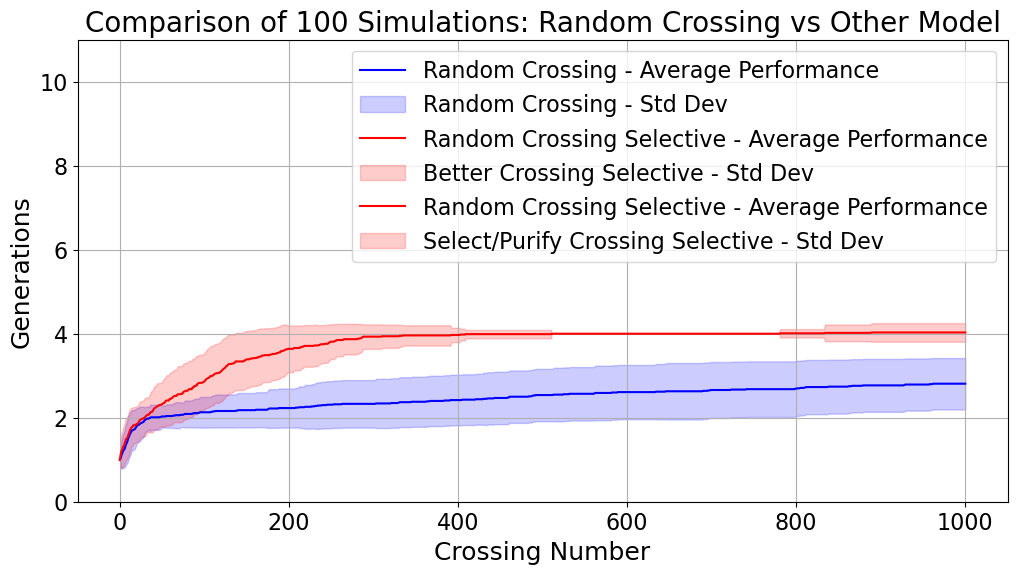

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert both to numpy arrays for easy aggregation
simulation_random_array = np.array(list_simulation_random)
simulation_better_gen_array = np.array(list_simulation_better_gen)
simulation_select_purify_array = np.array(list_simulation_select_purify)

# Calculate mean and standard deviation across simulations for both models
mean_performance_random = np.mean(simulation_random_array, axis=0)
std_performance_random = np.std(simulation_random_array, axis=0)

mean_performance_better_gen = np.mean(simulation_better_gen_array, axis=0)
std_performance_better_gen = np.std(simulation_better_gen_array, axis=0)

mean_performance_select_purify = np.mean(simulation_select_purify_array, axis=0)
std_performance_select_purify = np.std(simulation_select_purify_array, axis=0)

# Set global font sizes
plt.rcParams.update({
    'font.size': 16,          # Increase font size for all text
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 18,     # X and Y label font size
    'xtick.labelsize': 16,    # X-axis tick label font size
    'ytick.labelsize': 16,    # Y-axis tick label font size
    'legend.fontsize': 16,    # Legend font size
    'figure.figsize': (14, 10)  # Increase the figure size
})

# Plotting the results
plt.figure(figsize=(12, 6))  # Increase the figure size

# Plot for Random Crossing model
plt.plot(mean_performance_random, label='Random Crossing - Average Performance', color='blue')
plt.fill_between(range(crosing_number + 1), 
                 mean_performance_random - std_performance_random, 
                 mean_performance_random + std_performance_random, 
                 color='blue', alpha=0.2, label='Random Crossing - Std Dev')

# Plot for Other model
plt.plot(mean_performance_better_gen, label='Random Crossing Selective - Average Performance', color='red')
plt.fill_between(range(crosing_number + 1), 
                 mean_performance_better_gen - std_performance_better_gen, 
                 mean_performance_better_gen + std_performance_better_gen, 
                 color='red', alpha=0.2, label='Better Crossing Selective - Std Dev')

# Plot for Other model
plt.plot(mean_performance_select_purify, label='Random Crossing Selective - Average Performance', color='red')
plt.fill_between(range(crosing_number + 1), 
                 mean_performance_select_purify - std_performance_select_purify, 
                 mean_performance_select_purify + std_performance_select_purify, 
                 color='red', alpha=0.2, label='Select/Purify Crossing Selective - Std Dev')

# Customize the plot
plt.title('Comparison of 100 Simulations: Random Crossing vs Other Model')
plt.xlabel('Crossing Number')
plt.ylabel('Generations')
plt.ylim(0, 11)  # Set y-axis limits from 0 to 11
plt.legend()
plt.grid(True)
plt.show()